<a href="https://colab.research.google.com/github/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/blob/main/PyTorch_Linf_PGD_Untargeted_Attack_using_ImageNet_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [1]:
!git clone https://github.com/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST
%cd PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets

Cloning into 'PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 6056 (delta 23), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6056/6056), 628.31 MiB | 49.98 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Checking out files: 100% (5005/5005), done.
/content/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets


In [2]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Load ImageNet Classes</b>

In [4]:
from urllib.request import urlretrieve
import json

# load 1,000 labels from the ImageNet config file
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

print(imagenet_labels[18])

magpie


#### <b>Image Visualization</b>

In [5]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # resize the image size
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

In [6]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [7]:
# load an image and get a torch.Tensor object
def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0) # [1, 3, H, W]
    return image.to(device, torch.float)

In [8]:
image = image_loader('./ILSVRC2012_img_val_subset/18/ILSVRC2012_val_00000476.JPEG')

In [9]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

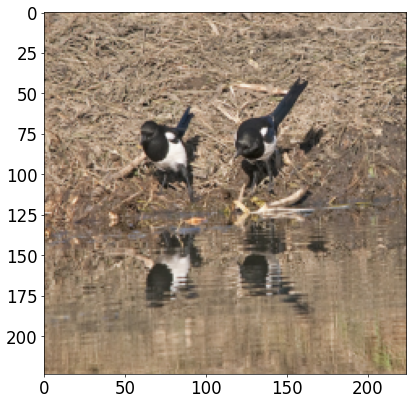

In [10]:
imshow(image)

#### <b>Load Pre-trained Classification Model</b>

In [11]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [12]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
).to(device).eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [13]:
outputs = model(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< Highest Confidence Classes >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class name: {imagenet_labels[i]} / Probability: {round(percentages[i].item(), 4)}%")

< Highest Confidence Classes >
Index: 18 / Class name: magpie / Probability: 76.3741%
Index: 80 / Class name: black grouse / Probability: 17.3179%
Index: 137 / Class name: American coot, marsh hen, mud hen, water hen, Fulica americana / Probability: 1.0765%
Index: 93 / Class name: hornbill / Probability: 0.6028%
Index: 128 / Class name: black stork, Ciconia nigra / Probability: 0.5908%


#### <b>Load Validation Dataset</b>

In [14]:
import os
from torchvision import datasets

data_dir = './ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
print('Validation dataset size:', len(val_dataset))

class_names = val_dataset.classes
print('The number of classes:', len(class_names))

Validation dataset size: 5000
The number of classes: 1000


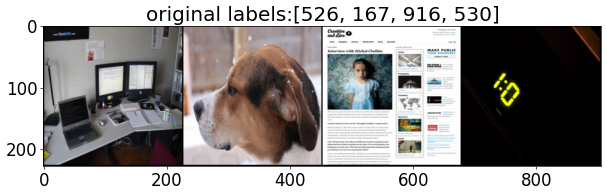

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: desk (526)
Image #2: English foxhound (167)
Image #3: web site, website, internet site, site (916)
Image #4: digital clock (530)


In [16]:
import torchvision
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(val_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')

#### <b>Validation Phase</b>

[Prediction Result Examples]


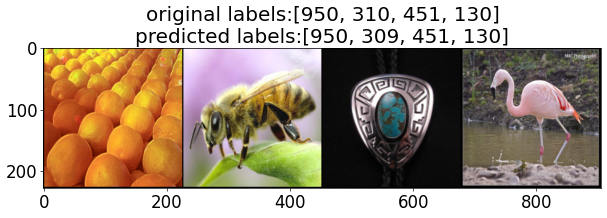

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: orange (950)
Image #2: ant, emmet, pismire (310)
Image #3: bolo tie, bolo, bola tie, bola (451)
Image #4: flamingo (130)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: orange (950)
Image #2: bee (309)
Image #3: bolo tie, bolo, bola tie, bola (451)
Image #4: flamingo (130)


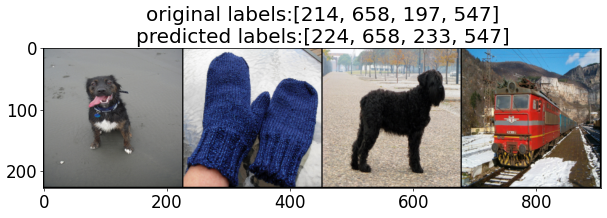

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Gordon setter (214)
Image #6: mitten (658)
Image #7: giant schnauzer (197)
Image #8: electric locomotive (547)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: groenendael (224)
Image #6: mitten (658)
Image #7: Bouvier des Flandres, Bouviers des Flandres (233)
Image #8: electric locomotive (547)
[Validation] Loss: 0.0619 Accuracy: 76.0600% Time elapsed: 33.4527s (total 5000 images)


In [17]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [19]:
!pip install foolbox
!pip install advertorch

In [20]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: 4-step PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 1 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


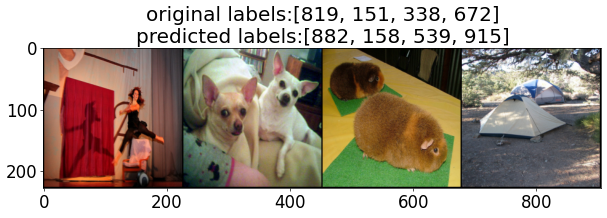

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: stage (819)
Image #2: Chihuahua (151)
Image #3: guinea pig, Cavia cobaya (338)
Image #4: mountain tent (672)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: vacuum, vacuum cleaner (882)
Image #2: toy terrier (158)
Image #3: doormat, welcome mat (539)
Image #4: yurt (915)


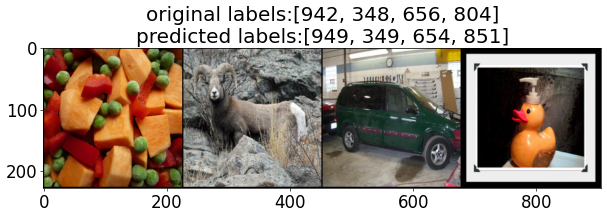

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: butternut squash (942)
Image #6: ram, tup (348)
Image #7: minivan (656)
Image #8: soap dispenser (804)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: strawberry (949)
Image #6: bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis (349)
Image #7: minibus (654)
Image #8: television, television system (851)
[Step #0] Loss: 0.8988 Accuracy: 0.0000% Time elapsed: 1.5840s (total 16 images)
[Step #10] Loss: 0.9339 Accuracy: 1.7045% Time elapsed: 8.6046s (total 176 images)
[Step #20] Loss: 0.8951 Accuracy: 1.7857% Time elapsed: 15.6988s (total 336 images)
[Step #30] Loss: 0.9343 Accuracy: 1.6129% Time elapsed: 22.8319s (total 496 images)
[Step #40] Loss: 0.9289 Accuracy: 1.6768% Time elapsed: 30.0605s (total 656 images)
[Step #50] Loss: 0.9256 Accuracy: 1.3480% Time elapsed: 37.3945s (total 816 images)
[Step #60] Loss: 0.9336 Accuracy: 1.4344% Time elapsed: 44.8569s (total 976 images)
[Step #70

In [24]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=1/255, nb_iter=4, eps_iter=1/255/2, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: 4-step PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 2 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


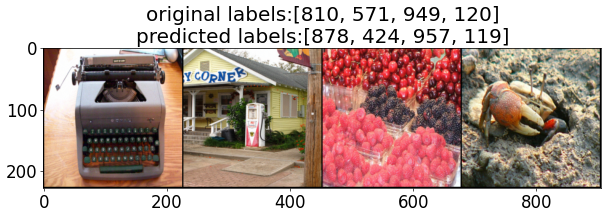

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: space bar (810)
Image #2: gas pump, gasoline pump, petrol pump, island dispenser (571)
Image #3: strawberry (949)
Image #4: fiddler crab (120)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: typewriter keyboard (878)
Image #2: barbershop (424)
Image #3: pomegranate (957)
Image #4: rock crab, Cancer irroratus (119)


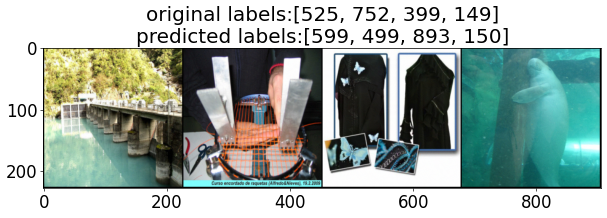

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: dam, dike, dyke (525)
Image #6: racket, racquet (752)
Image #7: abaya (399)
Image #8: dugong, Dugong dugon (149)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: honeycomb (599)
Image #6: cleaver, meat cleaver, chopper (499)
Image #7: wallet, billfold, notecase, pocketbook (893)
Image #8: sea lion (150)
[Step #0] Loss: 1.3909 Accuracy: 0.0000% Time elapsed: 1.7731s (total 16 images)
[Step #10] Loss: 1.3349 Accuracy: 0.0000% Time elapsed: 9.0616s (total 176 images)
[Step #20] Loss: 1.3211 Accuracy: 0.2976% Time elapsed: 16.3283s (total 336 images)
[Step #30] Loss: 1.3465 Accuracy: 0.2016% Time elapsed: 23.5991s (total 496 images)
[Step #40] Loss: 1.3412 Accuracy: 0.1524% Time elapsed: 30.8736s (total 656 images)
[Step #50] Loss: 1.3359 Accuracy: 0.1225% Time elapsed: 38.1521s (total 816 images)
[Step #60] Loss: 1.3413 Accuracy: 0.1025% Time elapsed: 45.4176s (total 976 images)
[Step #70] Loss: 1.3387 Accuracy: 0.0880% Time elapsed:

In [25]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2/255, nb_iter=4, eps_iter=2/255/2, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: 7-step PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 1 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


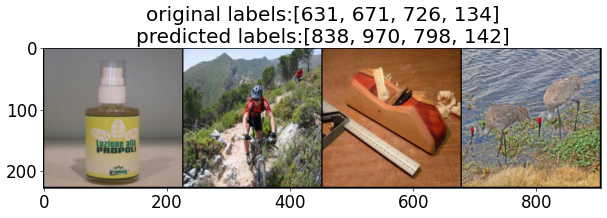

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: lotion (631)
Image #2: mountain bike, all-terrain bike, off-roader (671)
Image #3: plane, carpenter's plane, woodworking plane (726)
Image #4: crane (134)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: sunscreen, sunblock, sun blocker (838)
Image #2: alp (970)
Image #3: slide rule, slipstick (798)
Image #4: dowitcher (142)


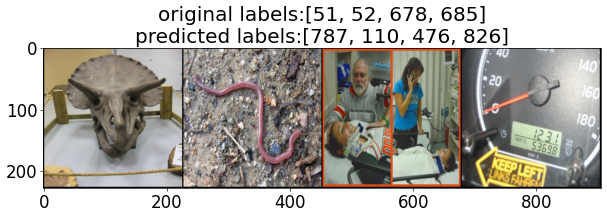

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: triceratops (51)
Image #6: thunder snake, worm snake, Carphophis amoenus (52)
Image #7: neck brace (678)
Image #8: odometer, hodometer, mileometer, milometer (685)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: shield, buckler (787)
Image #6: flatworm, platyhelminth (110)
Image #7: carousel, carrousel, merry-go-round, roundabout, whirligig (476)
Image #8: stopwatch, stop watch (826)
[Step #0] Loss: 0.9683 Accuracy: 6.2500% Time elapsed: 2.1934s (total 16 images)
[Step #10] Loss: 1.0464 Accuracy: 1.1364% Time elapsed: 14.1462s (total 176 images)
[Step #20] Loss: 1.0752 Accuracy: 1.4881% Time elapsed: 26.3470s (total 336 images)
[Step #30] Loss: 1.0922 Accuracy: 1.2097% Time elapsed: 38.8799s (total 496 images)
[Step #40] Loss: 1.1076 Accuracy: 0.9146% Time elapsed: 51.7056s (total 656 images)
[Step #50] Loss: 1.0982 Accuracy: 0.7353% Time elapsed: 64.2311s (total 816 images)
[Step #60] Loss: 1.0987 Accuracy: 0.6148% Time elapsed:

In [22]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=1/255, nb_iter=7, eps_iter=1/255/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: 7-step PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 2 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


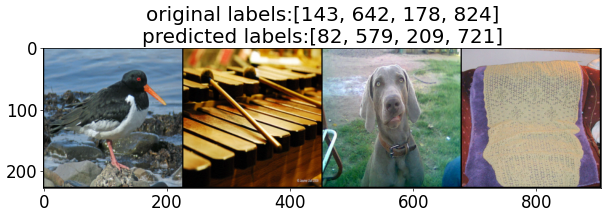

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: oystercatcher, oyster catcher (143)
Image #2: marimba, xylophone (642)
Image #3: Weimaraner (178)
Image #4: stole (824)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ruffed grouse, partridge, Bonasa umbellus (82)
Image #2: grand piano, grand (579)
Image #3: Chesapeake Bay retriever (209)
Image #4: pillow (721)


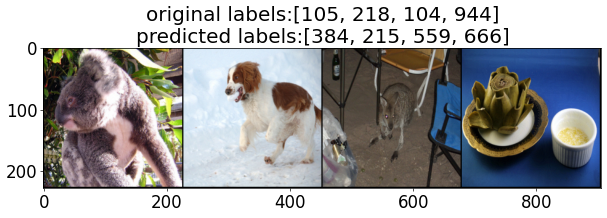

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus (105)
Image #6: Welsh springer spaniel (218)
Image #7: wallaby, brush kangaroo (104)
Image #8: artichoke, globe artichoke (944)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: indri, indris, Indri indri, Indri brevicaudatus (384)
Image #6: Brittany spaniel (215)
Image #7: folding chair (559)
Image #8: mortar (666)
[Step #0] Loss: 1.8269 Accuracy: 0.0000% Time elapsed: 2.1360s (total 16 images)
[Step #10] Loss: 1.6914 Accuracy: 0.0000% Time elapsed: 14.4176s (total 176 images)
[Step #20] Loss: 1.7046 Accuracy: 0.2976% Time elapsed: 26.8966s (total 336 images)
[Step #30] Loss: 1.7063 Accuracy: 0.2016% Time elapsed: 39.4387s (total 496 images)
[Step #40] Loss: 1.7331 Accuracy: 0.1524% Time elapsed: 51.7958s (total 656 images)
[Step #50] Loss: 1.7342 Accuracy: 0.1225% Time elapsed: 64.0975s (total 816 images)
[Step #60] Loss: 1.7203 Accuracy: 0.1025% Time elapsed: 

In [23]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=2/255, nb_iter=7, eps_iter=2/255/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: 7-step PGD
* <b>Images</b>: 5,000 valiation images
* <b>Epsilon size</b>: 4 / 255

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


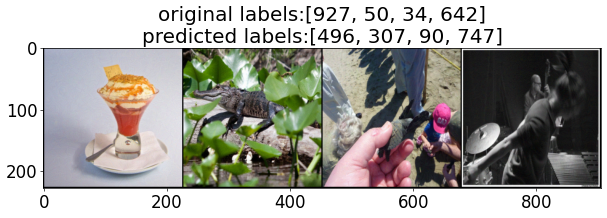

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: trifle (927)
Image #2: American alligator, Alligator mississipiensis (50)
Image #3: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea (34)
Image #4: marimba, xylophone (642)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Christmas stocking (496)
Image #2: weevil (307)
Image #3: lorikeet (90)
Image #4: punching bag, punch bag, punching ball, punchball (747)


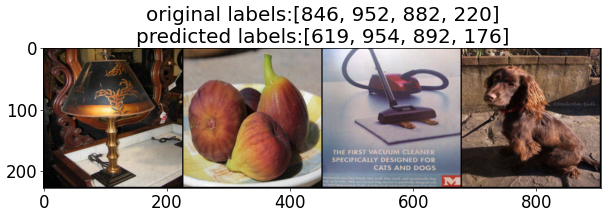

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: table lamp (846)
Image #6: fig (952)
Image #7: vacuum, vacuum cleaner (882)
Image #8: Sussex spaniel (220)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: lampshade, lamp shade (619)
Image #6: banana (954)
Image #7: wall clock (892)
Image #8: Saluki, gazelle hound (176)
[Step #0] Loss: 2.0729 Accuracy: 0.0000% Time elapsed: 2.2912s (total 16 images)
[Step #10] Loss: 2.2448 Accuracy: 0.0000% Time elapsed: 14.2290s (total 176 images)
[Step #20] Loss: 2.2485 Accuracy: 0.0000% Time elapsed: 26.3263s (total 336 images)
[Step #30] Loss: 2.2477 Accuracy: 0.0000% Time elapsed: 38.7280s (total 496 images)
[Step #40] Loss: 2.2503 Accuracy: 0.0000% Time elapsed: 51.4790s (total 656 images)
[Step #50] Loss: 2.2574 Accuracy: 0.1225% Time elapsed: 64.1421s (total 816 images)
[Step #60] Loss: 2.2634 Accuracy: 0.1025% Time elapsed: 76.4615s (total 976 images)
[Step #70] Loss: 2.2751 Accuracy: 0.0880% Time elapsed: 88.6385s (total 1136 images)
[S

In [26]:
import time
from advertorch.attacks import LinfPGDAttack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=4/255, nb_iter=7, eps_iter=4/255/4, clip_min=0.0, clip_max=1.0, targeted=False)

running_loss = 0.
running_corrects = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    adv_untargeted = adversary.perturb(inputs, labels) # adversarial attack

    outputs = model(adv_untargeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_untargeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_untargeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_untargeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))